In [2]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

original_dataset_dir = "C:/Users/chaha/Desktop/PestDetection_Project/Dataset"  
output_dir = "C:/Users/chaha/Desktop/PestDetection_Project/dataset_split"    

train_ratio = 0.8 
val_ratio = 0.1   
test_ratio = 0.1   

for split in ['train', 'val', 'test']:
    Path(f"{output_dir}/{split}").mkdir(parents=True, exist_ok=True)

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
        
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)

    train_files, temp_files = train_test_split(image_files, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    for split_name, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(output_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for filename in file_list:
            src = os.path.join(class_path, filename)
            dst = os.path.join(split_class_dir, filename)
            shutil.copy2(src, dst)

print(" Dataset successfully split into train/val/test folders!")


 Dataset successfully split into train/val/test folders!


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

pretrained_train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

pretrained_val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

cnn_train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # scales to [-1, 1]
])

cnn_val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader

data_dir = "C:/Users/chaha/Desktop/PestDetection_Project/dataset_split"
model_type = "pretrained"

if model_type == "pretrained":
    train_transform = pretrained_train_transforms
    val_test_transform = pretrained_val_test_transforms
elif model_type == "cnn":
    train_transform = cnn_train_transforms
    val_test_transform = cnn_val_test_transforms
else:
    raise ValueError("Invalid model type. Choose 'pretrained' or 'cnn'.")
    
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']
Training images: 5394
Validation images: 1331
Test images: 1337


## MobileNetV2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [11]:
model = models.mobilenet_v2(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)
            
        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1} - Train Acc: {100*correct/total:.2f}%, Val Acc: {val_acc:.2f}%\n")

In [13]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [54]:
evaluate(model, val_loader)

47.35883424408014

In [14]:
train_model(model, train_loader, val_loader, num_epochs=10)

Epoch [1/10]: 100%|██████████| 169/169 [02:38<00:00,  1.06it/s, acc=70.2, loss=0.718]


Epoch 1 - Train Acc: 70.21%, Val Acc: 84.15%



Epoch [2/10]: 100%|██████████| 169/169 [02:23<00:00,  1.18it/s, acc=82.8, loss=0.187]


Epoch 2 - Train Acc: 82.78%, Val Acc: 84.75%



Epoch [3/10]: 100%|██████████| 169/169 [02:24<00:00,  1.17it/s, acc=85, loss=0.922]  


Epoch 3 - Train Acc: 84.96%, Val Acc: 87.98%



Epoch [4/10]: 100%|██████████| 169/169 [02:22<00:00,  1.19it/s, acc=85.2, loss=0.62] 


Epoch 4 - Train Acc: 85.17%, Val Acc: 87.53%



Epoch [5/10]: 100%|██████████| 169/169 [02:31<00:00,  1.11it/s, acc=86, loss=0.474]  


Epoch 5 - Train Acc: 85.98%, Val Acc: 87.60%



Epoch [6/10]: 100%|██████████| 169/169 [02:43<00:00,  1.03it/s, acc=86.2, loss=0.576]


Epoch 6 - Train Acc: 86.15%, Val Acc: 88.20%



Epoch [7/10]: 100%|██████████| 169/169 [02:31<00:00,  1.12it/s, acc=85.9, loss=1.05] 


Epoch 7 - Train Acc: 85.89%, Val Acc: 88.88%



Epoch [8/10]: 100%|██████████| 169/169 [02:39<00:00,  1.06it/s, acc=86.3, loss=0.117]


Epoch 8 - Train Acc: 86.30%, Val Acc: 88.81%



Epoch [9/10]: 100%|██████████| 169/169 [02:32<00:00,  1.11it/s, acc=86.6, loss=0.86] 


Epoch 9 - Train Acc: 86.63%, Val Acc: 89.56%



Epoch [10/10]: 100%|██████████| 169/169 [02:45<00:00,  1.02it/s, acc=87, loss=0.417]  


Epoch 10 - Train Acc: 86.97%, Val Acc: 90.76%



In [28]:
torch.save(model.state_dict(), "mobilenetv2_pest_classifier.pth")
print("Model saved as mobilenetv2_pest_classifier.pth")

Model saved as mobilenetv2_pest_classifier.pth


In [15]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1) 
            correct += (preds == labels).sum().item()  
            total += labels.size(0) 

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

test_accuracy = test_model(model, test_loader)

Test Accuracy: 89.90%



 Classification Report:
              precision    recall  f1-score   support

        ants       0.93      0.95      0.94       133
        bees       0.98      0.92      0.95       131
      beetle       0.79      0.83      0.81       121
catterpillar       0.84      0.82      0.83       119
  earthworms       0.82      0.96      0.88        92
      earwig       0.78      0.84      0.80       128
 grasshopper       0.90      0.78      0.84       129
        moth       0.98      0.97      0.98       129
        slug       0.92      0.86      0.88        76
       snail       0.98      1.00      0.99        95
        wasp       0.92      0.93      0.92        95
      weevil       0.95      0.94      0.95        89

    accuracy                           0.90      1337
   macro avg       0.90      0.90      0.90      1337
weighted avg       0.90      0.90      0.90      1337

 Accuracy:  89.53%
 Precision: 89.80%
 Recall:    89.53%
 F1 Score:  89.55%


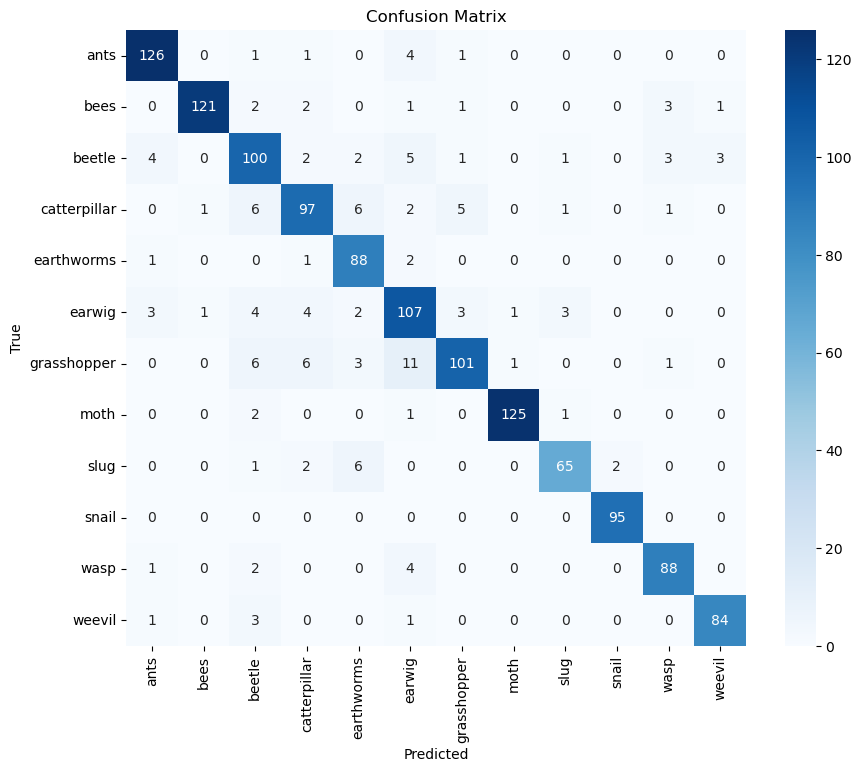

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluation function
def full_evaluation(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    print(f" Accuracy:  {acc * 100:.2f}%")
    print(f" Precision: {prec * 100:.2f}%")
    print(f" Recall:    {rec * 100:.2f}%")
    print(f" F1 Score:  {f1 * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Run full evaluation on test set
full_evaluation(model, test_loader, train_dataset.classes)


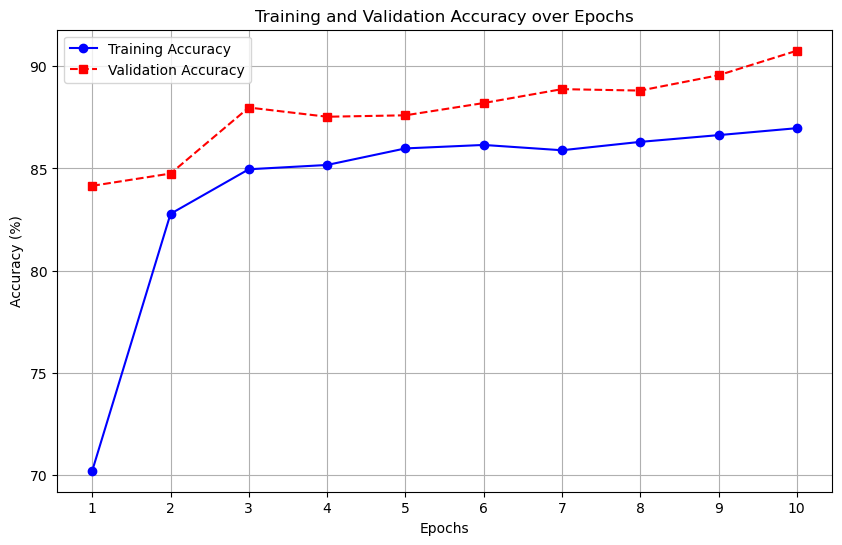

In [16]:
import matplotlib.pyplot as plt

# Epochs data from the training logs
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_acc = [70.21, 82.78, 84.96, 85.17, 85.98, 86.15, 85.89, 86.30, 86.63, 86.97]
val_acc = [84.15, 84.75, 87.98, 87.53, 87.60, 88.20, 88.88, 88.81, 89.56, 90.76]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', linestyle='--', color='r')

# Add titles and labels
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


## RestNet50

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [59]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.layer4.parameters():
    param.requires_grad = True
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

C:\Users\chaha\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
evaluate(model, val_loader)

8.925318761384336

In [31]:
num_epochs = 15

In [33]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [34]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)

    print(f" Epoch {epoch+1} - Loss: {avg_loss:.4f} - Val Accuracy: {val_acc:.2f}%")

Epoch 1/15: 100%|██████████| 138/138 [07:35<00:00,  3.30s/it]


 Epoch 1 - Loss: 0.6785 - Val Accuracy: 87.98%


Epoch 2/15: 100%|██████████| 138/138 [07:55<00:00,  3.45s/it]


 Epoch 2 - Loss: 0.2706 - Val Accuracy: 89.80%


Epoch 3/15: 100%|██████████| 138/138 [08:01<00:00,  3.49s/it]


 Epoch 3 - Loss: 0.1741 - Val Accuracy: 89.80%


Epoch 4/15: 100%|██████████| 138/138 [08:01<00:00,  3.49s/it]


 Epoch 4 - Loss: 0.1052 - Val Accuracy: 89.44%


Epoch 5/15: 100%|██████████| 138/138 [07:43<00:00,  3.36s/it]


 Epoch 5 - Loss: 0.0864 - Val Accuracy: 91.80%


Epoch 6/15: 100%|██████████| 138/138 [07:51<00:00,  3.41s/it]


 Epoch 6 - Loss: 0.0828 - Val Accuracy: 89.80%


Epoch 7/15: 100%|██████████| 138/138 [07:48<00:00,  3.39s/it]


 Epoch 7 - Loss: 0.0852 - Val Accuracy: 89.62%


Epoch 8/15: 100%|██████████| 138/138 [07:21<00:00,  3.20s/it]


 Epoch 8 - Loss: 0.0476 - Val Accuracy: 91.99%


Epoch 9/15: 100%|██████████| 138/138 [09:58<00:00,  4.34s/it]


 Epoch 9 - Loss: 0.0294 - Val Accuracy: 89.98%


Epoch 10/15: 100%|██████████| 138/138 [08:06<00:00,  3.53s/it]


 Epoch 10 - Loss: 0.0254 - Val Accuracy: 90.35%


Epoch 11/15: 100%|██████████| 138/138 [07:45<00:00,  3.37s/it]


 Epoch 11 - Loss: 0.0384 - Val Accuracy: 89.25%


Epoch 12/15: 100%|██████████| 138/138 [08:23<00:00,  3.65s/it]


 Epoch 12 - Loss: 0.0318 - Val Accuracy: 90.35%


Epoch 13/15: 100%|██████████| 138/138 [07:48<00:00,  3.39s/it]


 Epoch 13 - Loss: 0.0351 - Val Accuracy: 91.07%


Epoch 14/15: 100%|██████████| 138/138 [07:23<00:00,  3.22s/it]


 Epoch 14 - Loss: 0.0253 - Val Accuracy: 91.62%


Epoch 15/15: 100%|██████████| 138/138 [07:42<00:00,  3.35s/it]


 Epoch 15 - Loss: 0.0379 - Val Accuracy: 90.16%


In [35]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 90.07%


In [36]:
torch.save(model.state_dict(), "resnet50_finetuned_pest_detection.pth")
print("Fine-tuned model saved as resnet50_finetuned_pest_detection.pth")

Fine-tuned model saved as resnet50_finetuned_pest_detection.pth


## EfficientNetB0

In [38]:
!pip install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16458 sha256=40434633e987cac432496a5b6d8ff5a29fdf2d4f18db1fb6941e925fafb1db41
  Stored in directory: c:\users\chaha\appdata\local\pip\cache\wheels\9c\3f\43\e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [39]:
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\chaha\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\chaha/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:05<00:00, 4.09MB/s]


In [41]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return model

In [44]:
test_acc = evaluate(model,test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 81.05%


In [45]:
torch.save(model.state_dict(), "efficientnetb0_pest_detection.pth")
print(" Model saved as 'efficientnetb0_pest_detection.pth'")

 Model saved as 'efficientnetb0_pest_detection.pth'


## CNN

In [46]:
from torchvision import datasets
from torch.utils.data import DataLoader

data_dir = "C:/Users/chaha/Desktop/PestDetection_Project/dataset_split"
model_type = "cnn"

if model_type == "pretrained":
    train_transform = pretrained_train_transforms
    val_test_transform = pretrained_val_test_transforms
elif model_type == "cnn":
    train_transform = cnn_train_transforms
    val_test_transform = cnn_val_test_transforms
else:
    raise ValueError("Invalid model type. Choose 'pretrained' or 'cnn'.")
    
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']
Training images: 4391
Validation images: 549
Test images: 554


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

In [48]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = 12 
model = SimpleCNN(num_classes=num_classes)

In [49]:
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [50]:
num_epochs = 10
train_losses, val_accuracies = [], []

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [51]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation Accuracy
    val_acc = evaluate(model, val_loader)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/10: 100%|██████████| 138/138 [03:41<00:00,  1.61s/it]


Epoch [1/10], Loss: 2.3611, Val Accuracy: 28.60%


Epoch 2/10: 100%|██████████| 138/138 [03:36<00:00,  1.57s/it]


Epoch [2/10], Loss: 2.0650, Val Accuracy: 34.43%


Epoch 3/10: 100%|██████████| 138/138 [03:38<00:00,  1.58s/it]


Epoch [3/10], Loss: 1.8656, Val Accuracy: 36.98%


Epoch 4/10: 100%|██████████| 138/138 [03:40<00:00,  1.59s/it]


Epoch [4/10], Loss: 1.7464, Val Accuracy: 42.08%


Epoch 5/10: 100%|██████████| 138/138 [03:44<00:00,  1.63s/it]


Epoch [5/10], Loss: 1.6517, Val Accuracy: 42.81%


Epoch 6/10: 100%|██████████| 138/138 [04:00<00:00,  1.74s/it]


Epoch [6/10], Loss: 1.5523, Val Accuracy: 45.90%


Epoch 7/10: 100%|██████████| 138/138 [03:51<00:00,  1.68s/it]


Epoch [7/10], Loss: 1.4808, Val Accuracy: 41.89%


Epoch 8/10: 100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [8/10], Loss: 1.4073, Val Accuracy: 44.63%


Epoch 9/10: 100%|██████████| 138/138 [03:59<00:00,  1.73s/it]


Epoch [9/10], Loss: 1.3437, Val Accuracy: 46.99%


Epoch 10/10: 100%|██████████| 138/138 [04:17<00:00,  1.87s/it]


Epoch [10/10], Loss: 1.2626, Val Accuracy: 47.36%


In [52]:
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 49.28%


In [53]:
torch.save(model.state_dict(), "simple_cnn_model.pth")
print("Model saved as simple_cnn_model.pth")

Model saved as simple_cnn_model.pth


## EfficientNetB0

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

In [15]:
# Load pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)

# Freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two blocks of the model (fine-tuning)
for param in model.features[-2:].parameters():
    param.requires_grad = True

# Modify the final fully connected layer for your task (e.g., 12 classes for your dataset)
num_classes = 12  # Set according to your dataset
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [17]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [18]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    return train_acc_list, val_acc_list

In [19]:
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10)

Epoch [1/10]: 100%|██████████| 169/169 [03:34<00:00,  1.27s/it, acc=59.3, loss=1.24] 


Epoch 1: Train Acc = 59.31%, Val Acc = 77.91%


Epoch [2/10]: 100%|██████████| 169/169 [03:31<00:00,  1.25s/it, acc=79.7, loss=0.722]


Epoch 2: Train Acc = 79.68%, Val Acc = 85.27%


Epoch [3/10]: 100%|██████████| 169/169 [03:32<00:00,  1.26s/it, acc=83.3, loss=0.712]


Epoch 3: Train Acc = 83.33%, Val Acc = 88.13%


Epoch [4/10]: 100%|██████████| 169/169 [03:43<00:00,  1.32s/it, acc=85.9, loss=0.696]


Epoch 4: Train Acc = 85.89%, Val Acc = 90.08%


Epoch [5/10]: 100%|██████████| 169/169 [03:39<00:00,  1.30s/it, acc=87.7, loss=0.425]


Epoch 5: Train Acc = 87.67%, Val Acc = 90.91%


Epoch [6/10]: 100%|██████████| 169/169 [03:32<00:00,  1.26s/it, acc=89.4, loss=0.411]


Epoch 6: Train Acc = 89.36%, Val Acc = 91.66%


Epoch [7/10]: 100%|██████████| 169/169 [03:31<00:00,  1.25s/it, acc=89.8, loss=0.227] 


Epoch 7: Train Acc = 89.80%, Val Acc = 92.26%


Epoch [8/10]: 100%|██████████| 169/169 [03:31<00:00,  1.25s/it, acc=90.9, loss=0.491] 


Epoch 8: Train Acc = 90.93%, Val Acc = 93.39%


Epoch [9/10]: 100%|██████████| 169/169 [03:30<00:00,  1.25s/it, acc=92, loss=0.542]   


Epoch 9: Train Acc = 91.95%, Val Acc = 93.84%


Epoch [10/10]: 100%|██████████| 169/169 [03:45<00:00,  1.34s/it, acc=92.6, loss=0.0998]


Epoch 10: Train Acc = 92.58%, Val Acc = 95.19%


In [20]:
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 95.96%


In [26]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

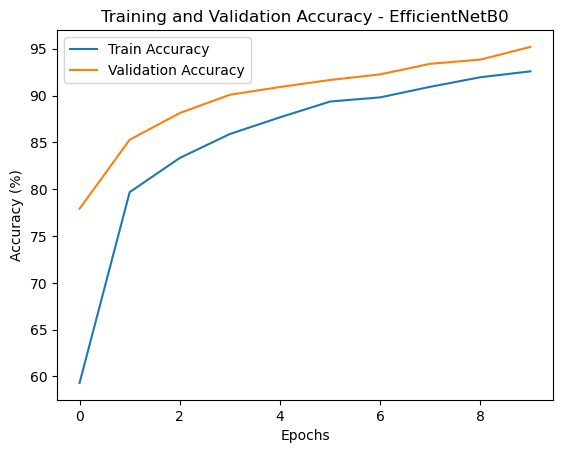

In [24]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy - EfficientNetB0')
plt.legend()

plt.show()

In [28]:
torch.save(model.state_dict(), "efficientnetb0_pest_classifier_1.pth")
print(" Model saved as efficientnetb0_pest_classifier.pth")

 Model saved as efficientnetb0_pest_classifier.pth



 Classification Report:
              precision    recall  f1-score   support

        ants       0.96      0.98      0.97       133
        bees       0.99      0.97      0.98       131
      beetle       0.92      0.89      0.90       121
catterpillar       0.95      0.94      0.95       119
  earthworms       0.96      0.97      0.96        92
      earwig       0.95      0.93      0.94       128
 grasshopper       0.95      0.96      0.96       129
        moth       0.98      0.99      0.99       129
        slug       0.96      0.92      0.94        76
       snail       0.98      1.00      0.99        95
        wasp       0.95      0.99      0.97        95
      weevil       0.97      0.97      0.97        89

    accuracy                           0.96      1337
   macro avg       0.96      0.96      0.96      1337
weighted avg       0.96      0.96      0.96      1337

 Accuracy:  95.96%
 Precision: 95.96%
 Recall:    95.96%
 F1 Score:  95.95%


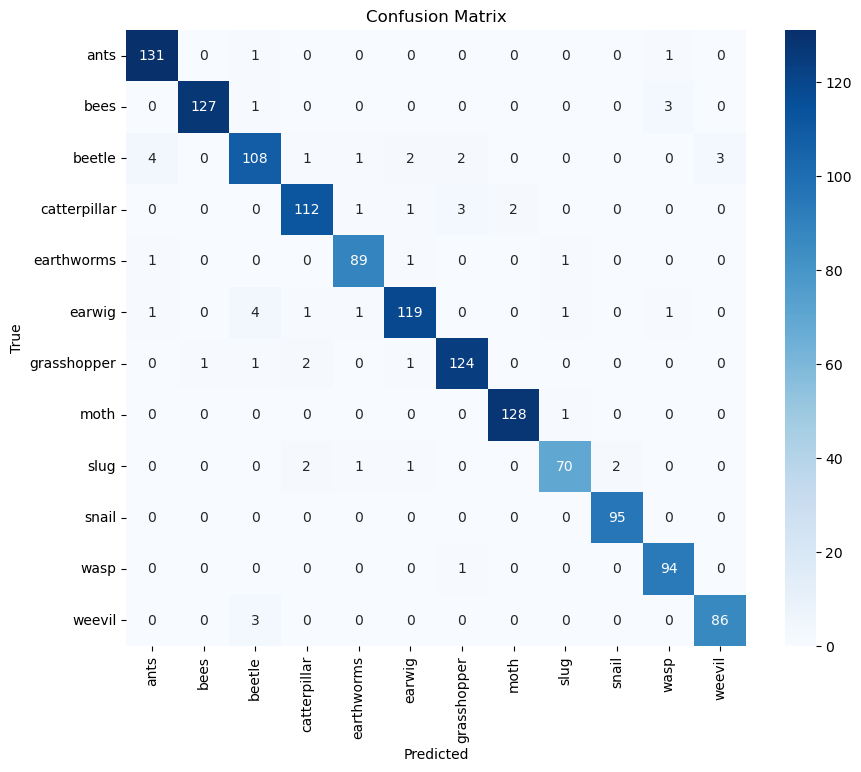

In [27]:
def full_evaluation(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    print(f" Accuracy:  {acc * 100:.2f}%")
    print(f" Precision: {prec * 100:.2f}%")
    print(f" Recall:    {rec * 100:.2f}%")
    print(f" F1 Score:  {f1 * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Run full evaluation on test set
full_evaluation(model, test_loader, train_dataset.classes)

In [31]:
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Redefine classifier head
num_classes = len(class_names)  # use your saved class_names list
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Fine-tune only layer4
for param in model.layer4.parameters():
    param.requires_grad = True

# Load trained weights
model.load_state_dict(torch.load("resnet50_finetuned_pest_detection.pth"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


 Classification Report:
              precision    recall  f1-score   support

        ants       0.94      0.98      0.96       133
        bees       0.95      0.96      0.95       131
      beetle       0.90      0.85      0.88       121
catterpillar       0.91      0.88      0.90       119
  earthworms       0.94      0.98      0.96        92
      earwig       0.90      0.93      0.92       128
 grasshopper       0.95      0.91      0.93       129
        moth       0.98      1.00      0.99       129
        slug       0.97      0.96      0.97        76
       snail       1.00      0.99      0.99        95
        wasp       0.97      0.98      0.97        95
      weevil       1.00      0.99      0.99        89

    accuracy                           0.95      1337
   macro avg       0.95      0.95      0.95      1337
weighted avg       0.95      0.95      0.95      1337

 Accuracy:  94.91%
 Precision: 94.90%
 Recall:    94.91%
 F1 Score:  94.88%


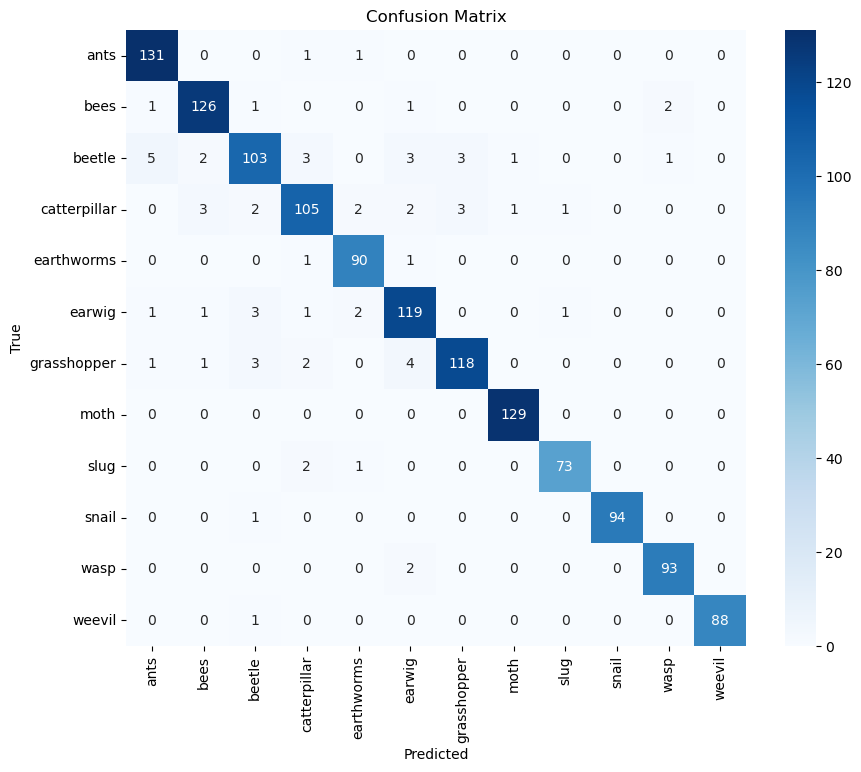

In [34]:
def full_evaluation(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    print(f" Accuracy:  {acc * 100:.2f}%")
    print(f" Precision: {prec * 100:.2f}%")
    print(f" Recall:    {rec * 100:.2f}%")
    print(f" F1 Score:  {f1 * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Run full evaluation on test set
full_evaluation(model, test_loader, train_dataset.classes)

In [35]:
model = models.mobilenet_v2(pretrained=True)

# Freeze all feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head
num_classes = len(class_names)   # e.g. 12
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Optionally fine‑tune classifier only (or unfreeze more layers if you'd like)
for param in model.classifier.parameters():
    param.requires_grad = True

# Load your trained weights
model.load_state_dict(torch.load("mobilenetv2_pest_classifier.pth"))
model.to(device)
model.eval()

C:\Users\chaha\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chaha\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=


 Classification Report:
              precision    recall  f1-score   support

        ants       0.91      0.94      0.93       133
        bees       0.90      0.94      0.92       131
      beetle       0.89      0.68      0.77       121
catterpillar       0.78      0.76      0.77       119
  earthworms       0.81      0.95      0.87        92
      earwig       0.80      0.83      0.81       128
 grasshopper       0.85      0.84      0.85       129
        moth       0.96      0.97      0.97       129
        slug       0.91      0.80      0.85        76
       snail       0.98      0.99      0.98        95
        wasp       0.92      0.94      0.93        95
      weevil       0.91      1.00      0.95        89

    accuracy                           0.88      1337
   macro avg       0.89      0.89      0.88      1337
weighted avg       0.88      0.88      0.88      1337

 Accuracy:  88.26%
 Precision: 88.33%
 Recall:    88.26%
 F1 Score:  88.08%


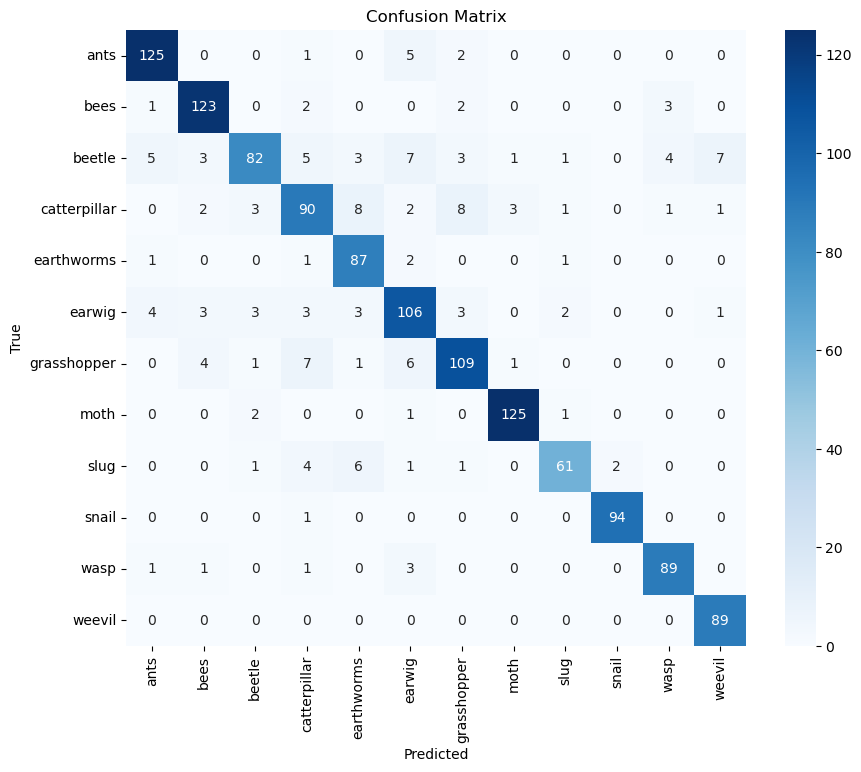

In [36]:
full_evaluation(model, test_loader, class_names)

In [37]:
model = models.efficientnet_b0(pretrained=True)

# Freeze all feature layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier layer for your number of classes
num_classes = 12  # Number of classes (12 in your case)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load("efficientnetb0_pest_detection.pth"))
model = model.to(device)


C:\Users\chaha\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chaha\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Classification Report:
              precision    recall  f1-score   support

        ants       0.77      0.89      0.83       133
        bees       0.77      0.89      0.83       131
      beetle       0.78      0.60      0.68       121
catterpillar       0.62      0.57      0.59       119
  earthworms       0.75      0.78      0.77        92
      earwig       0.88      0.58      0.70       128
 grasshopper       0.72      0.79      0.76       129
        moth       0.91      0.92      0.92       129
        slug       0.76      0.68      0.72        76
       snail       0.89      0.97      0.93        95
        wasp       0.82      0.85      0.84        95
      weevil       0.81      0.96      0.88        89

    accuracy                           0.79      1337
   macro avg       0.79      0.79      0.79      1337
weighted avg       0.79      0.79      0.78      1337

 Accuracy:  78.83%
 Precision: 78.99%
 Recall:    78.83%
 F1 Score:  78.33%


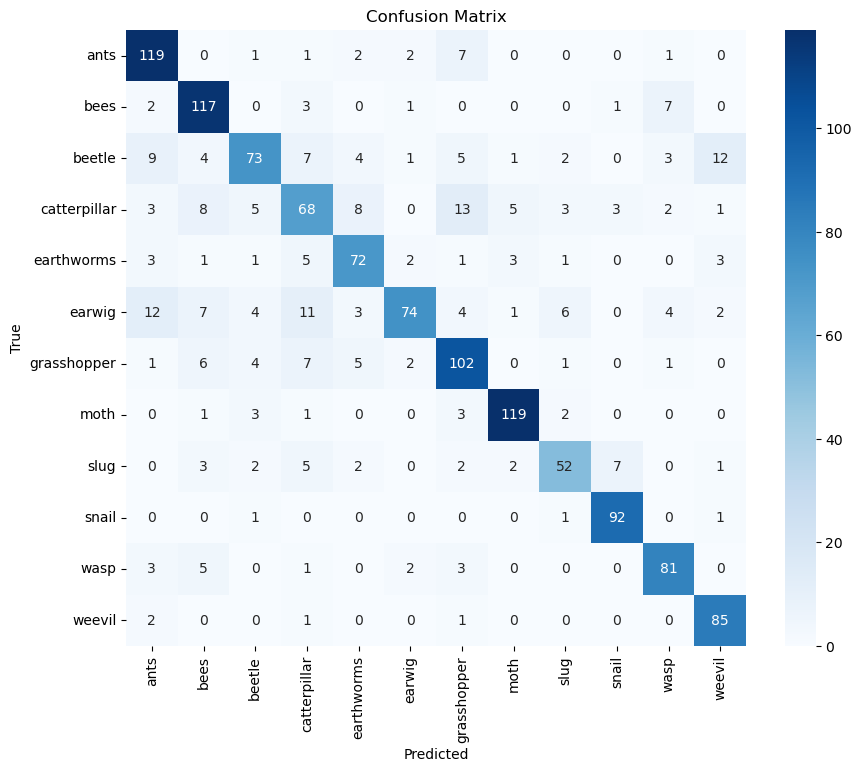

In [38]:
full_evaluation(model, test_loader, class_names)

In [41]:
import torch
import torch.nn as nn

# Define the SimpleCNN model again
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust if your image size is different
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [42]:
# Load to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
num_classes = 12
model = SimpleCNN(num_classes=num_classes)
model.load_state_dict(torch.load("simple_cnn_model.pth", map_location=device))
model = model.to(device)

print("Model loaded successfully!")


Model loaded successfully!



 Classification Report:
              precision    recall  f1-score   support

        ants       0.35      0.56      0.43       133
        bees       0.40      0.74      0.52       131
      beetle       0.21      0.60      0.31       121
catterpillar       0.39      0.26      0.31       119
  earthworms       0.68      0.16      0.26        92
      earwig       0.41      0.14      0.21       128
 grasshopper       0.62      0.18      0.28       129
        moth       0.79      0.47      0.59       129
        slug       0.47      0.18      0.26        76
       snail       0.69      0.35      0.46        95
        wasp       0.53      0.74      0.62        95
      weevil       0.66      0.47      0.55        89

    accuracy                           0.41      1337
   macro avg       0.52      0.40      0.40      1337
weighted avg       0.51      0.41      0.40      1337

 Accuracy:  41.14%
 Precision: 50.63%
 Recall:    41.14%
 F1 Score:  39.88%


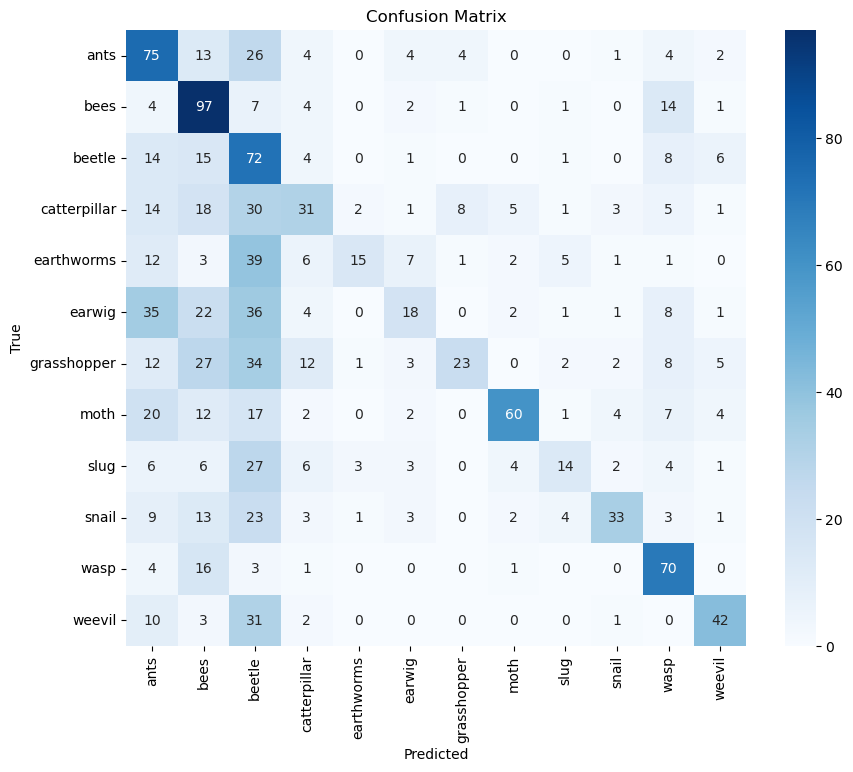

In [43]:

full_evaluation(model, test_loader, train_dataset.classes)
